## **Data Ingestion**

In [1]:
import sys
sys.path.append('../')

!pwd

/c/Users/Vladimir/Desktop/Everything/Work/ARLIS/development/incubator-flagon-distill/prototypes


In [2]:
!ls

__pycache__
data1
data2
data3
helpers.py
model.pth
model_2.pth
model_3.pth
Prototype 1.ipynb
Prototype 2.ipynb
Prototype 3.ipynb


In [3]:
import datetime
import distill
import json
import networkx as nx
import os
import pandas as pd
import plotly.express as px
import re
from helpers import *

In [12]:
def get_file_paths(directory_path):
    path_list = []
    for root, directories, files in os.walk(directory_path):
        for file in files:
            # Different workflow needed for Amir next time
            # Need to ensure sessionID is updating in Madeline's logs
            if file != "logs_nome_amir.json" and (not "Logs-Workflow3" in file):
                path = os.path.join(root, file)
                path_list.append(path)
    return path_list

liam_vlad_dir = (os.getcwd() + '/data3') # Note: Sundial did not work
liam_vlad = get_file_paths(liam_vlad_dir)
all_paths = [path.replace("\\", "/") for path in liam_vlad]

print("File Paths:")
for path in all_paths:
    print(path)


File Paths:
C:/Users/Vladimir/Desktop/Everything/Work/ARLIS/development/incubator-flagon-distill/prototypes/data3/logs_nome_liam.json
C:/Users/Vladimir/Desktop/Everything/Work/ARLIS/development/incubator-flagon-distill/prototypes/data3/logs_nome_vlad.json


In [13]:
def combine_json_to_dataframe(file_paths):
    data_list = []
    for file_path in file_paths:
        with open(file_path, 'r', encoding='utf-8') as file:
            data = json.load(file)
            data_list.append(data)

    combined_data = pd.concat([pd.DataFrame(data) for data in data_list], ignore_index=True)
    return combined_data

df = combine_json_to_dataframe(all_paths)
# df = pd.read_json("data3/logs_nome_vlad.json")
df.head()

,target,path,pageUrl,pageTitle,pageReferrer,browser,clientTime,microTime,location,scrnRes,type,logType,userAction,details,userId,toolVersion,toolName,useraleVersion,sessionID
0,Window,[Window],https://nome.vgihub.geointservices.io/way/1434...,Way: ‪Reckord Armory‬ (‪143466875‬) | MapEdit,https://nome.vgihub.geointservices.io/,"{'browser': 'firefox', 'version': '114.0.0'}",1688062434247,0.0,"{'x': None, 'y': None}","{'width': 1440, 'height': 489}",resize,raw,True,"{'width': 1453, 'height': 865}",nobody,None,test_app,2.3.0,session_1688062135244
1,div#map.leaflet-container leaflet-touch leafle...,[div#map.leaflet-container leaflet-touch leafl...,https://nome.vgihub.geointservices.io/way/1434...,Way: ‪Reckord Armory‬ (‪143466875‬) | MapEdit,https://nome.vgihub.geointservices.io/,"{'browser': 'firefox', 'version': '114.0.0'}",1688062437423,0.0,"{'x': 756, 'y': 314}","{'width': 1440, 'height': 489}",click,raw,True,"{'clicks': 1, 'ctrl': False, 'alt': False, 'sh...",nobody,None,test_app,2.3.0,session_1688062135244
2,NaN,NaN,https://nome.vgihub.geointservices.io/way/1434...,Way: ‪Reckord Armory‬ (‪143466875‬) | MapEdit,https://nome.vgihub.geointservices.io/,"{'browser': 'firefox', 'version': '114.0.0'}",1688062437461,NaN,NaN,"{'width': 1440, 'height': 489}",viewChange,custom,True,"{'zoom': '18', 'latitude': '38.98564', 'longit...",nobody,None,test_app,2.3.0,session_1688062135244
3,path.[object SVGAnimatedString],"[path.[object SVGAnimatedString], g.[object SV...",https://nome.vgihub.geointservices.io/way/1434...,Way: ‪Reckord Armory‬ (‪143466875‬) | MapEdit,https://nome.vgihub.geointservices.io/,"{'browser': 'firefox', 'version': '114.0.0'}",1688062440642,0.0,"{'x': 554, 'y': 269}","{'width': 1440, 'height': 489}",click,raw,True,"{'clicks': 1, 'ctrl': False, 'alt': False, 'sh...",nobody,None,test_app,2.3.0,session_1688062135244
4,NaN,NaN,https://nome.vgihub.geointservices.io/way/2340...,Way: ‪McKeldin Library‬ (‪23408799‬) | MapEdit,https://nome.vgihub.geointservices.io/,"{'browser': 'firefox', 'version': '114.0.0'}",1688062441543,NaN,NaN,"{'width': 1440, 'height': 489}",visit,custom,True,"{'class': 'Way', 'id': '23408799', 'name': 'Mc...",nobody,None,test_app,2.3.0,session_1688062135244


In [14]:
print(df.columns)
print( type(df['details']) )
print( type(df['details'].iloc[-1]) )
print( (df['details'].iloc[-1]) )

Index(['target', 'path', 'pageUrl', 'pageTitle', 'pageReferrer', 'browser',
       'clientTime', 'microTime', 'location', 'scrnRes', 'type', 'logType',
       'userAction', 'details', 'userId', 'toolVersion', 'toolName',
       'useraleVersion', 'sessionID'],
      dtype='object')
<class 'pandas.core.series.Series'>
<class 'dict'>
{'active': True, 'audible': False, 'incognito': False, 'index': 2, 'muted': False, 'pinned': False, 'selected': True, 'tabId': 691774691, 'title': '', 'url': '', 'windowId': 691774592}


## Preprocessing

In [15]:
# def get_partition(log, partition_elements):
#     # A list of the identical matches between what's in the path and color_dict keys
#     partition = list(set(log['path']) & set(partition_elements))
#     if len(partition) == 1:
#         return partition[0]
#     if len(partition) == 0:
#         return "Other"
#     print("uh oh")
#     return "uh oh"

def get_partition(log, partition_elements):
    name = log['details']['name']
    if name in set(partition_elements):
        return name
    else:
        return "Other"
    print("uh oh")
    return "uh oh"

Note from 6/16/23 meeting: Paths for annotations will be the same, but further log data will allow us to differentiate. Purpose is to be able to trace back to the path, regardless how relevant that path is

Prev path graph code

In [6]:
# def get_color_graph(log_dict, color_dict, partition_func):
#     targets = []
#     partition_dict = {}
#     label_dict = {}
#     for log in log_dict.values():
#         # Append this log's path as a string, to targets
#         targets.append(''.join(log['path'])) #This is the path as a string
#         # {this path : partition type ('Other' or 'div-leaflet-pane')}
#         partition_dict[targets[-1]] = partition_func(log, color_dict.keys())
#         # {this path : log's label}
#         label_dict[targets[-1]] = log['target']
        
#     # Make a pairwise list of the logs' paths as edges
#     edges = list(nx.utils.pairwise(targets))

#     # x and y are the nodes connected by the edge, and v is the capacity of the edge
#     graph = nx.DiGraph((x, y, {'capacity': v}) for (x, y), v in collections.Counter(edges).items())
#     # Sets partition and label attributes for each node in the graph
#     nx.set_node_attributes(graph, partition_dict, "partition")
#     nx.set_node_attributes(graph, label_dict, "label")
#     # Sets node values according to the partition of the node's log
#     colors = [color_dict[p] for p in nx.get_node_attributes(graph, "partition").values()]
#     # Returns a tuple containing the constructed graph (graph) and the list of colors (colors)
#     return (graph, colors)

# def setup(file, date_type):
#     with open(file) as json_file:
#         raw_data = json.load(json_file)

#     # Data = {sessionID : {logUUID : log}}
#     data = {}
#     curr_sess = {}
#     curr_id = next(iter(raw_data))['sessionID']
#     # For each log of type 'click' ('visit' logs don't have paths), attach it to the log's uuid in the curr_sess dictionary
#     for log in raw_data:
#         if 'type' in log and 'path' in log and (log['type'] == 'click'):
#             # If the sessionID is different from before, attach the sorted curr_sess dictionary to the curr_id in data
#             # and reset it
#             if log['sessionID'] != curr_id:
#                 data[curr_id] = dict(sorted(curr_sess.items(), key=lambda kv: kv[1]['clientTime']))
#                 curr_id = log['sessionID']
#                 curr_sess = {}
#             # Convert clientTime to specified type and add it to the current session dictionary
#             client_time = log['clientTime']
#             log['clientTime'] = convert_time(date_type, client_time)
#             curr_sess[distill.getUUID(log)] = log
#     # Add the final session's dict to the data dict
#     data[curr_id] = dict(sorted(curr_sess.items(), key=lambda kv: kv[1]['clientTime']))

#     return data

Current visit name graph code

In [18]:
def convert_time(date_type, client_time):
    if date_type == "integer":
        return distill.epoch_to_datetime(client_time)
    elif date_type == "datetime":
        return pd.to_datetime(client_time, unit='ms', origin='unix')
    else:
        return client_time
    
def get_color_graph(log_dict, color_dict, partition_func):
    targets = []
    partition_dict = {}
    label_dict = {}
    for log in log_dict.values():
        # Append this log's name to targets
        targets.append(''.join(log['details']['name']))
        # {this path : partition type ('MD Science Center', 'National Aquarium', etc.)}
        partition_dict[targets[-1]] = partition_func(log, color_dict.keys())
        # {this path : log's "label"}
        label_dict[targets[-1]] = log['details']['name']
        
    # Make a pairwise list of the logs' paths as edges
    edges = list(nx.utils.pairwise(targets))

    # x and y are the nodes connected by the edge, and v is the capacity/direction of the edge
    graph = nx.DiGraph((x, y, {'capacity': v}) for (x, y), v in collections.Counter(edges).items())
    # Sets partition and label attributes for each node in the graph
    nx.set_node_attributes(graph, partition_dict, "partition")
    nx.set_node_attributes(graph, label_dict, "label")
    # Sets node values according to the partition of the node's log
    colors = [color_dict[p] for p in nx.get_node_attributes(graph, "partition").values()]
    # Returns a tuple containing the constructed graph (graph) and the list of colors (colors)
    return (graph, colors)

def setup(file, date_type):
    with open(file, 'r', encoding='utf-8') as json_file:
        raw_data = json.load(json_file)

    # Data = {sessionID : {logUUID : log}}
    data = {}
    curr_sess = {}
    curr_id = next(iter(raw_data))['sessionID']
    # For each log of type 'visit' or 'click', attach it to the log's uuid in the curr_sess dictionary
    for log in raw_data:
        if 'type' in log and (log['type'] == 'visit') and ('name' in log['details']):
            # If the sessionID is different from before, attach the sorted curr_sess dictionary to the curr_id in data
            # and reset it
            if log['sessionID'] != curr_id:
                data[curr_id] = dict(sorted(curr_sess.items(), key=lambda kv: kv[1]['clientTime']))
                curr_id = log['sessionID']
                curr_sess = {}
            # Convert clientTime to specified type and add it to the current session dictionary
            client_time = log['clientTime']
            log['clientTime'] = convert_time(date_type, client_time)
            curr_sess[distill.getUUID(log)] = log
    # Add the final session's dict to the data dict
    data[curr_id] = dict(sorted(curr_sess.items(), key=lambda kv: kv[1]['clientTime']))
    
    return data

C:\Users\Vladimir\AppData\Local\Temp\ipykernel_13932\1799288566.py:27: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  f = plt.figure()


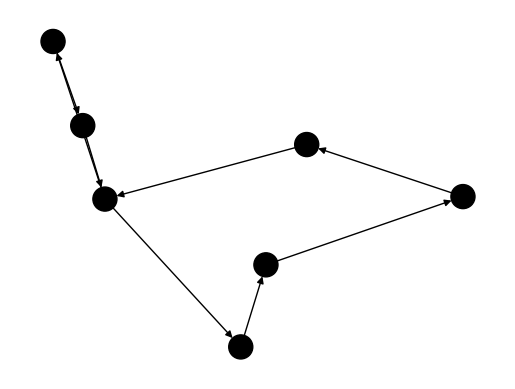

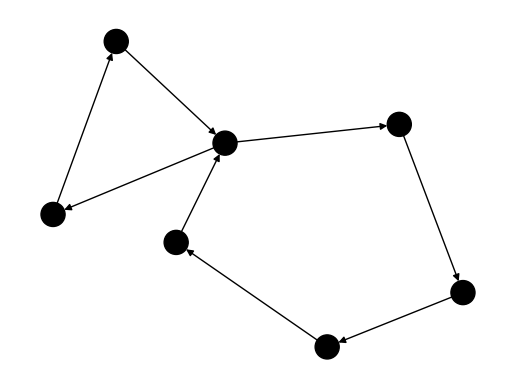

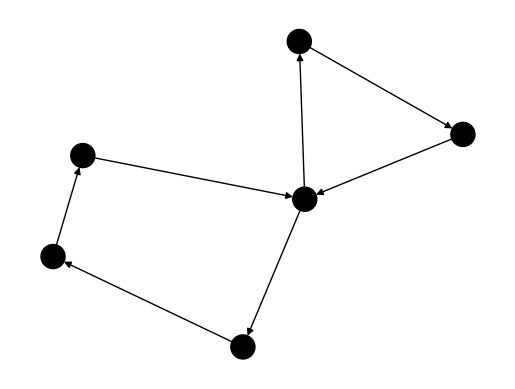

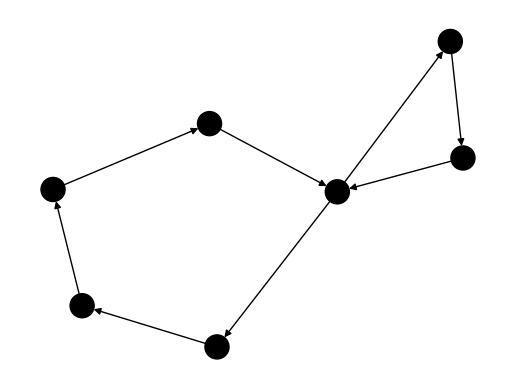

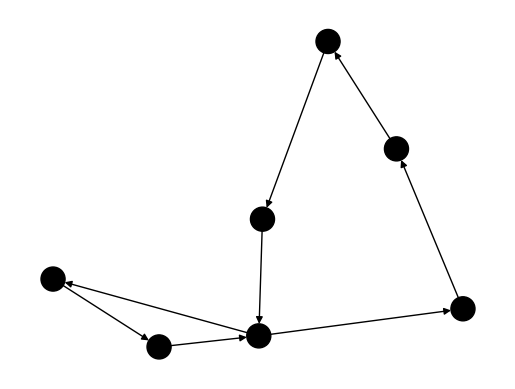

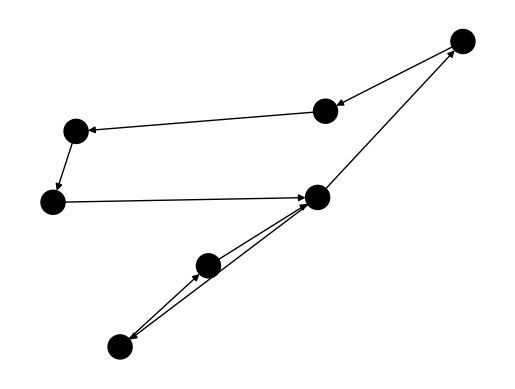

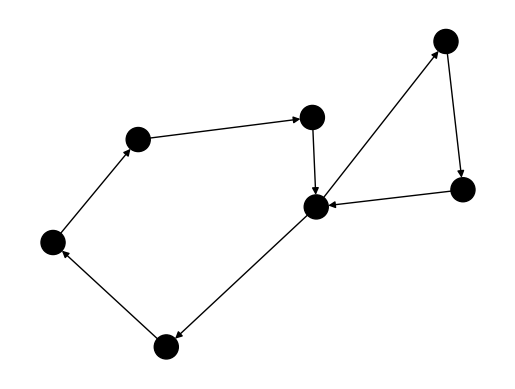

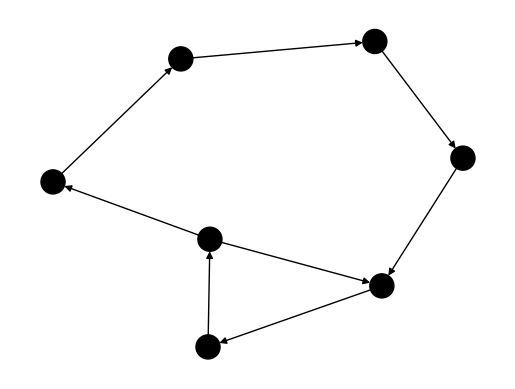

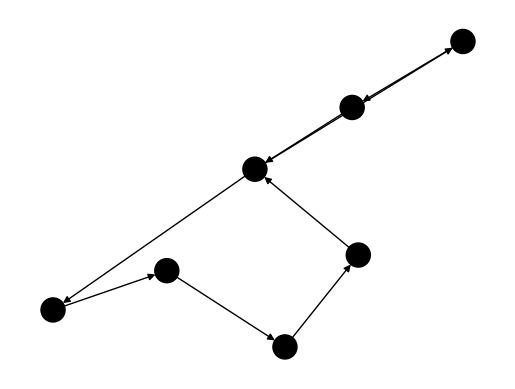

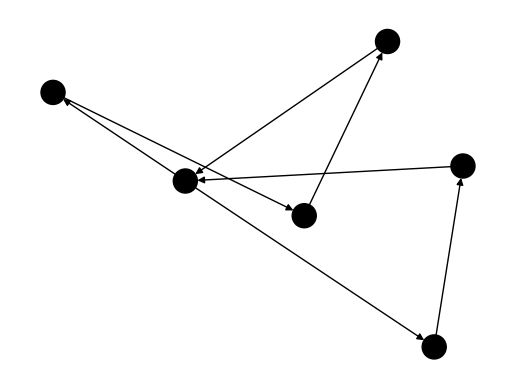

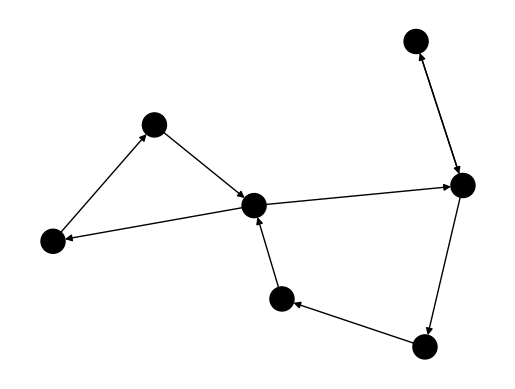

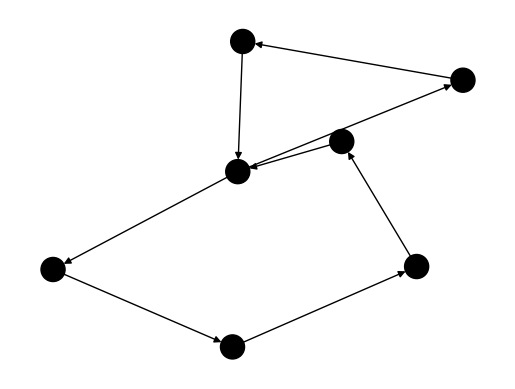

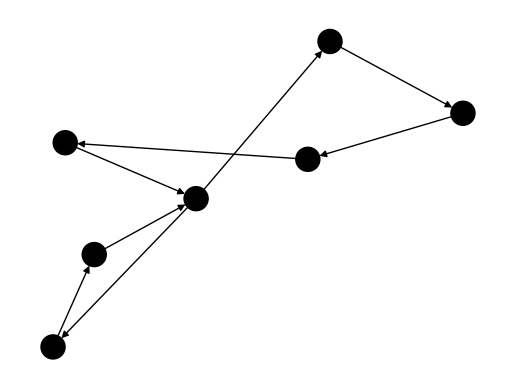

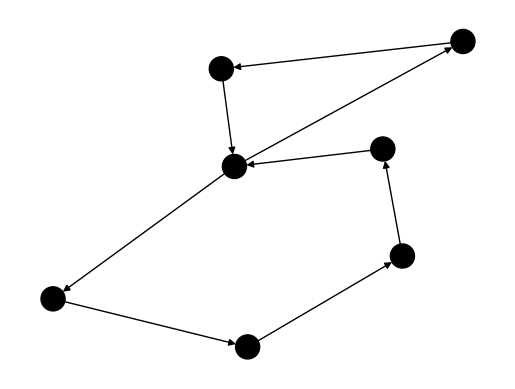

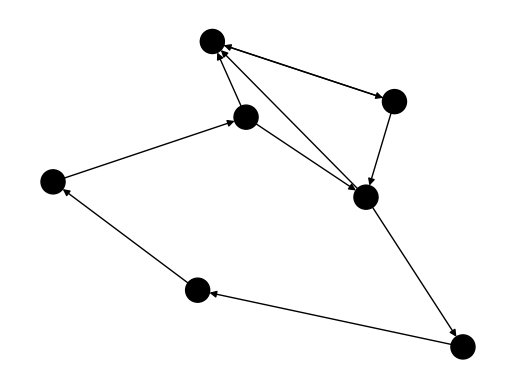

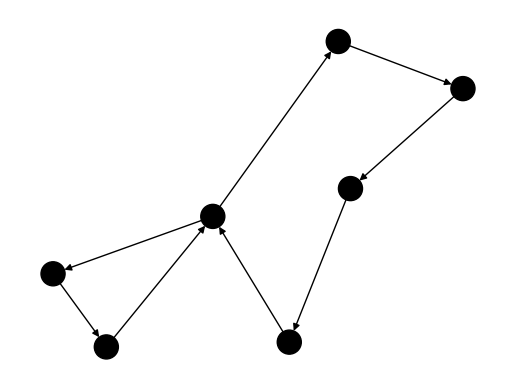

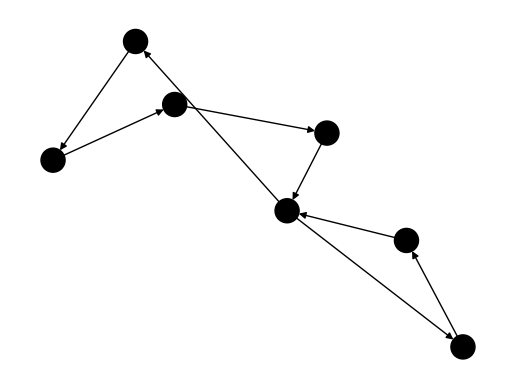

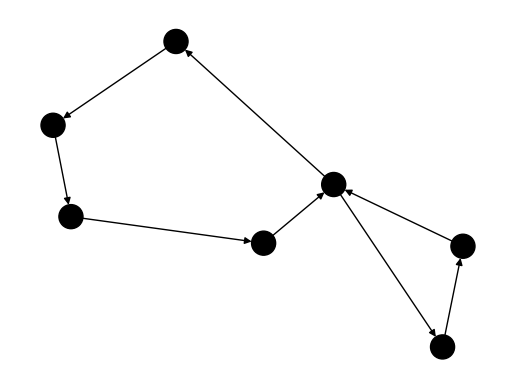

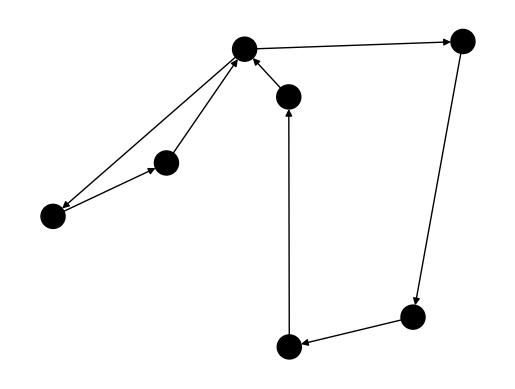

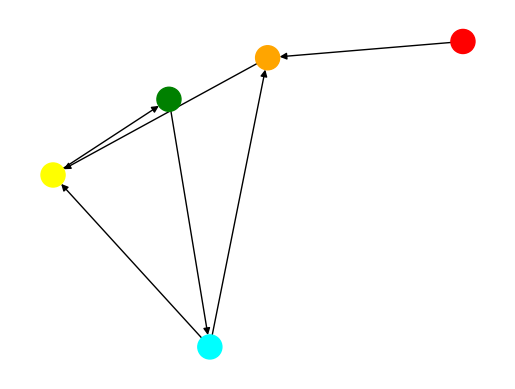

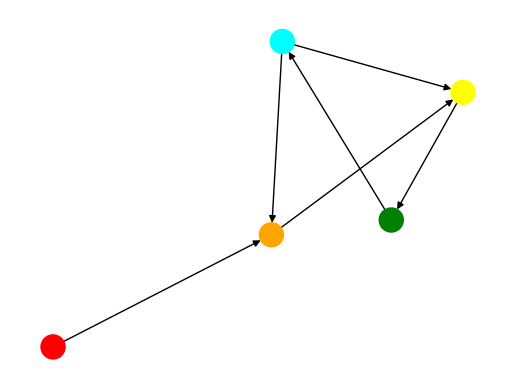

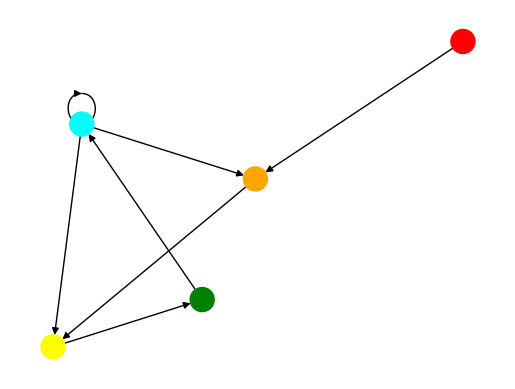

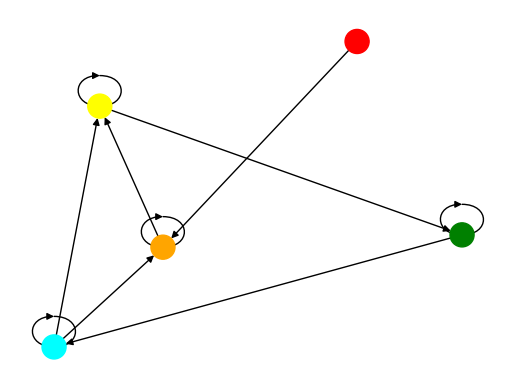

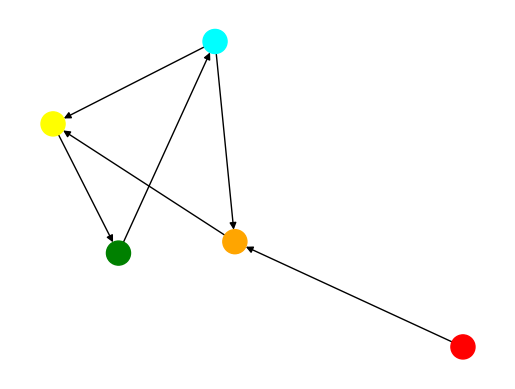

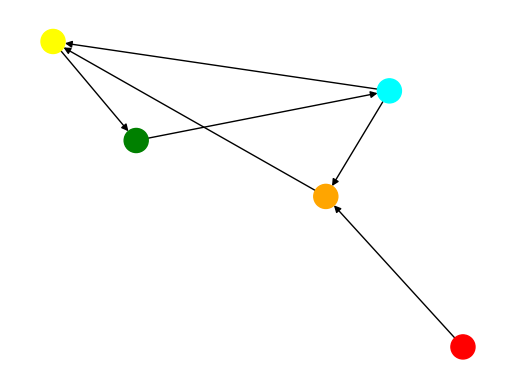

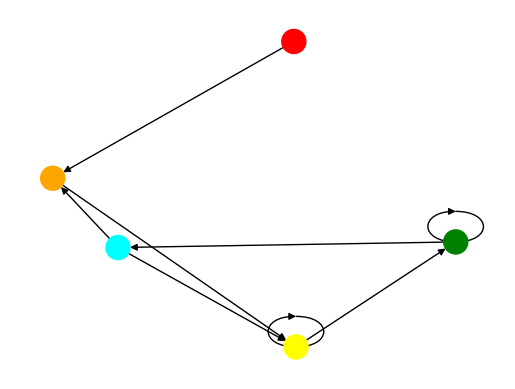

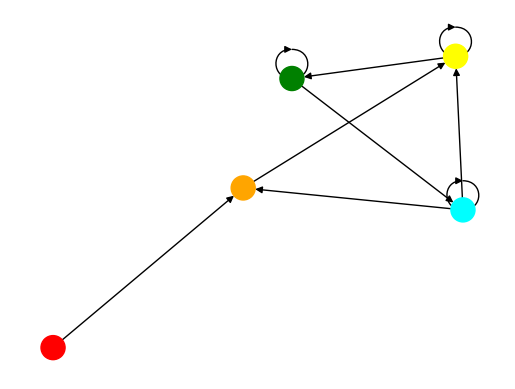

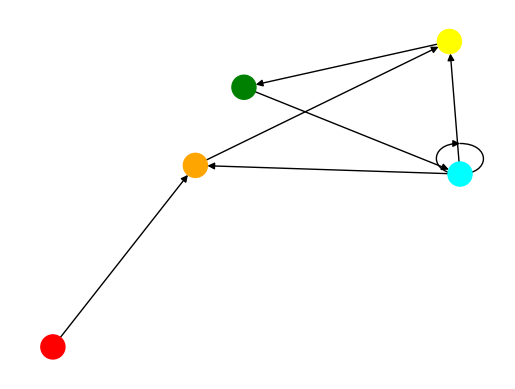

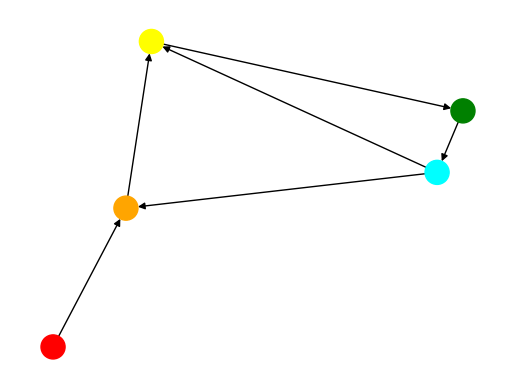

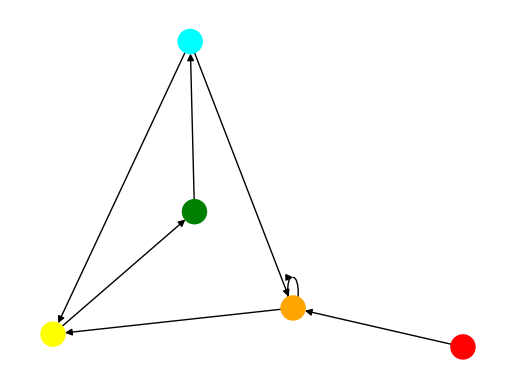

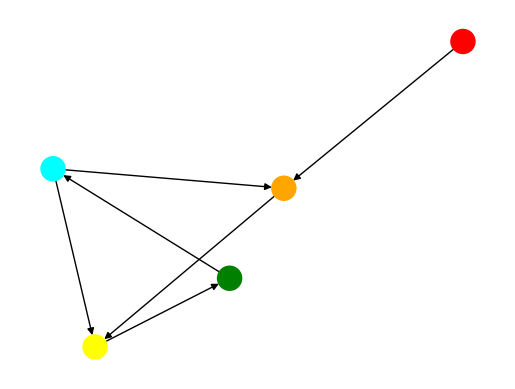

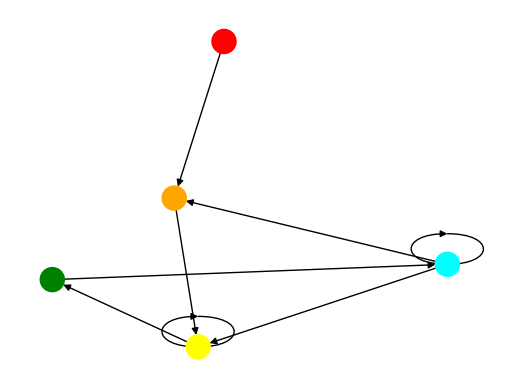

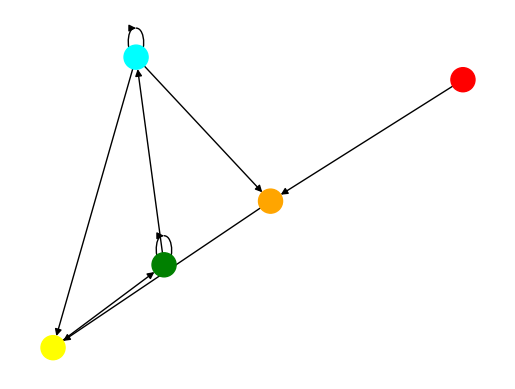

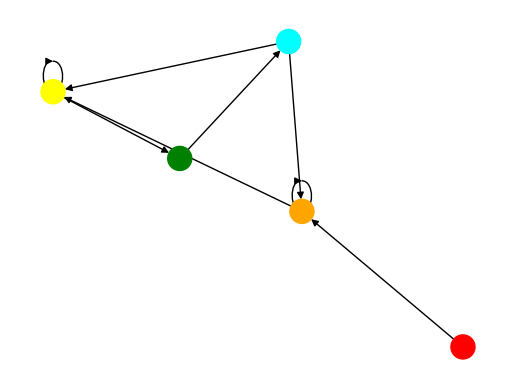

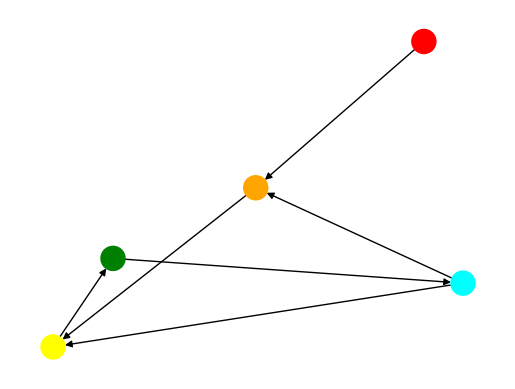

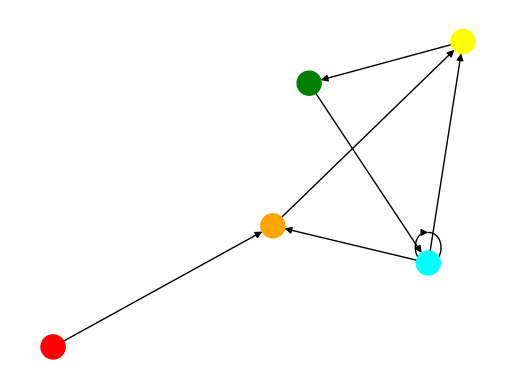

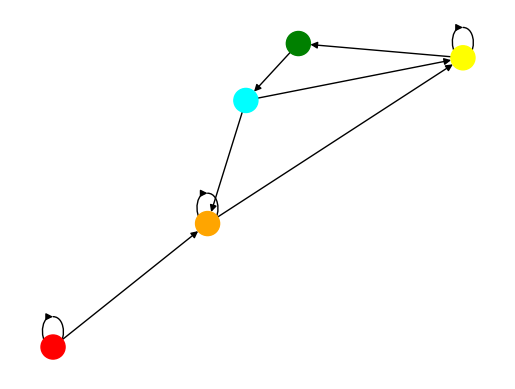

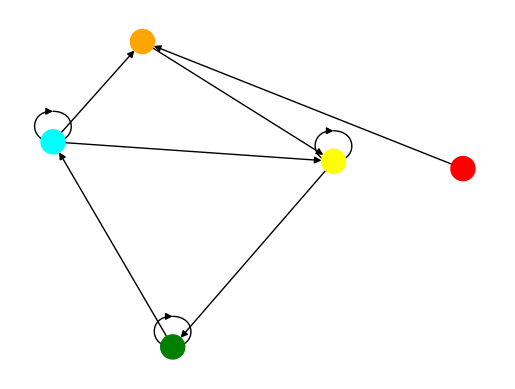

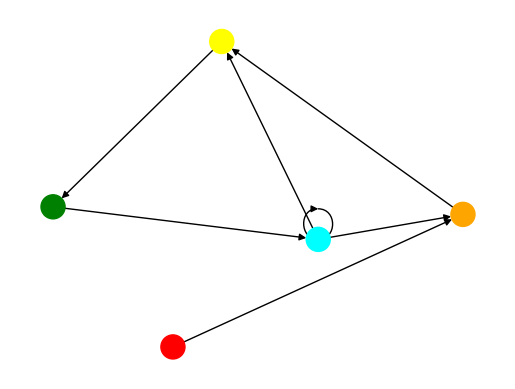

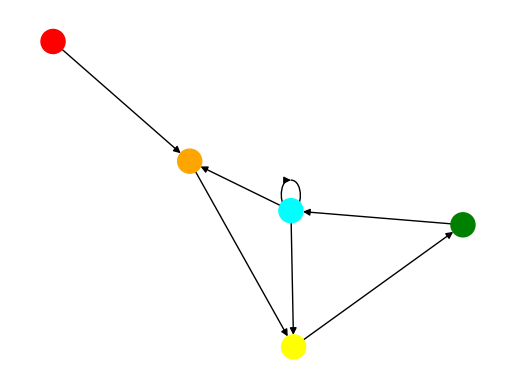

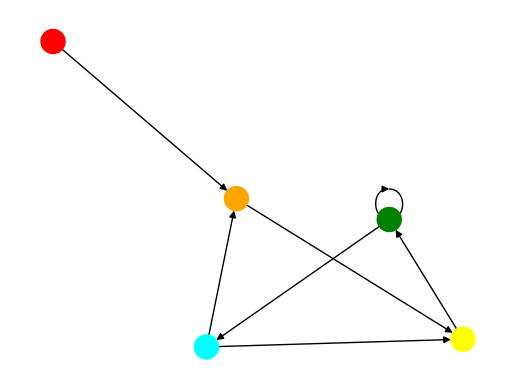

In [19]:
# Path to the logs
# files = ["data3/logs_nome_vlad.json"]
files = all_paths

# Color coding the different elements for the Sankey and Directed graphs
# color_dict = {'Other':'green', 'div.leaflet-pane leaflet-map-pane':'red'}
color_dict = {'Maryland Science Center and Planetarium':'red', 
              'USS Constellation':'orange', 'World Trade Center':'yellow', 
              'National Aquarium':'green', 'USCGC Taney':'cyan', 
              'Pratt Street Pavilion':'blue', 'Light Street Pavilion':'purple',
              'Chesapeake':'pink', 'Other':'black'}

# creating a list to store the generated directed graphs
graphs = {}

# Assembling data into a dictionary from each file
data = {}
for file in files:
    if len(data) == 0:
        data = setup(file, "datetime")
    else:
        data.update( setup(file, "datetime") )
    
for sessID,logs in data.items():
    # creating the directed graph and assigning the previously defined color-code
    (graph, colors) = get_color_graph(logs, color_dict, get_partition)
    f = plt.figure()
    # drawing the di-graph
    nx.draw(graph, pos=nx.spring_layout(graph), node_color=colors, ax=f.add_subplot(111))
    # adding the digraph to our previously defined 'graphs' list.
    graphs[sessID] = graph

In [20]:
print("Example of the name data we want: ", (data['session_1688066755015']['session_16880667550152023-06-29 20:16:38.223000customvisit']['details']['name'] ) ) 

Example of the name data we want:  Maryland Science Center and Planetarium


Now we have all the graphs of temporally sorted logs indexed by their sessions. The next step is turning them into lists to be fed into the model:

First, we get the important information of every log in the session

In [21]:
sess_elements = {}
for sessID,logs in data.items():
    for logID,log in logs.items():
        elem_name = log['details']['name']
        if (not sessID in sess_elements.keys()):
            sess_elements[sessID] = [ elem_name ]
        else:
            sess_elements[sessID] += [ elem_name ]

In [22]:
print("Example of a session list after extracting desired data: ", sess_elements['session_1688066755015'])

Example of a session list after extracting desired data:  ['Maryland Science Center and Planetarium', 'USS Constellation', 'World Trade Center', 'National Aquarium', 'USCGC Taney', 'USS Constellation', 'World Trade Center', 'National Aquarium', 'USCGC Taney', 'World Trade Center', 'National Aquarium', 'USCGC Taney']


## Partitioning

Partitioning can be done a number of ways according to the number of future user interactions ("visit" logs' name elements) we'd like to see. As a general rule of thumb, the model cannot predict a number of interactions more than the number of interactions its given as input (if input is length 7, model can't predict more than the next 7 interactions). This is by the nature of the LSTM model. Thus, I try stretching its capabilities as much as I can with n = len(session list) / 2

In the future, I could fix the limited prediction size with 'dummy' padding elments, have the outputs feed into the model for more outputs, or some other thing so that a greater n-many outputs is possible. But maybe the data we'll eventually have will be rich enough (input-wise) that this won't be a problem?

In [23]:
def split_list(lst):
    length = len(lst)
    middle = length // 2
    if length % 2 == 1:  # If the length is odd
        middle += 1  # Increase the middle index by 1 for the first half
    return (lst[:middle], lst[middle:])

In [28]:
import pandas as pd

# The smallest workflow we have is size 6, so anything less than that gets cut
print("Original # of tasks/sessions: ", len(data))
data = [sess_elements[sessID] for sessID in sess_elements.keys() if len(sess_elements[sessID]) > 5]
print("Refined # of tasks/sessions: ", len(data))

s = set()
for sublist in data:
    s.update(sublist)
vocab = list(s)
print(vocab)

# Using a specific n value:
# n = 4
# inputs = [s[:-n] for s in data], targets = [s[-n:] for s in data]
# data_tups = [(s[:-n], s[-n:]) for s in data]

# Spliting the list:
data_tups = [split_list(s) for s in data]
# print("data: ", data_tups)
df = pd.DataFrame(data_tups, columns=["inputs", "targets"])
df

Original # of tasks/sessions:  41
Refined # of tasks/sessions:  41
['USS Constellation', 'Lee Building', 'National Aquarium', 'Marie Mount Hall', 'McKeldin Library', 'Reckord Armory', 'USCGC Taney', 'Mitchell Building', 'Sundial', 'Memorial Chapel', 'World Trade Center', 'Maryland Science Center and Planetarium']


,inputs,targets
0,"[McKeldin Library, Sundial, Marie Mount Hall, ...","[Memorial Chapel, Lee Building, Reckord Armory..."
1,"[McKeldin Library, Sundial, Marie Mount Hall, ...","[Memorial Chapel, Lee Building, Reckord Armory..."
2,"[McKeldin Library, Sundial, Marie Mount Hall, ...","[Marie Mount Hall, Lee Building, Reckord Armor..."
3,"[McKeldin Library, Sundial, Marie Mount Hall, ...","[Memorial Chapel, Lee Building, Reckord Armory..."
4,"[McKeldin Library, Sundial, Marie Mount Hall, ...","[Memorial Chapel, Lee Building, Reckord Armory..."
5,"[McKeldin Library, Sundial, Marie Mount Hall, ...","[Memorial Chapel, Lee Building, Reckord Armory..."
6,"[McKeldin Library, Sundial, Marie Mount Hall, ...","[Memorial Chapel, Lee Building, Reckord Armory..."
7,"[McKeldin Library, Sundial, Marie Mount Hall, ...","[Memorial Chapel, Lee Building, Reckord Armory..."
8,"[McKeldin Library, Sundial, Marie Mount Hall, ...","[Memorial Chapel, Lee Building, Reckord Armory..."
9,"[McKeldin Library, Sundial, Marie Mount Hall, ...","[Marie Mount Hall, Lee Building, Reckord Armor..."


## **Model** (Training and Evaluation)

**Working LSTM model:**

Attempted probabalistic approach:

In [108]:
# import torch
# import torch.nn as nn
# import torch.optim as optim

# n = 4
# vocab = ['Maryland Science Center and Planetarium', 'USS Constellation', 'World Trade Center', 'National Aquarium', 'USCGC Taney', 'Pratt Street Pavilion', 'Light Street Pavilion', 'Chesapeake']
# # Define the vocabulary and index-to-word mapping
# word2idx = {w: i for i, w in enumerate(vocab)}
# idx2word = {i: w for i, w in enumerate(vocab)}

# # Convert a tensor of vocab indices into a tensor of each element's probability
# # of being each index's word in the vocab
# def idx_to_probs(n, vocab, input_tensor):
#     output_tensor = torch.zeros((n, len(vocab)))
#     for i, idx in enumerate(input_tensor):
#         output_tensor[i][idx] = 1
#     return output_tensor

# class LSTM(nn.Module):
#     def __init__(self, input_size, hidden_size, output_size):
#         super(LSTM, self).__init__()
#         self.hidden_size = hidden_size
#         self.lstm = nn.LSTM(input_size, hidden_size)
#         self.embedding = nn.Embedding(input_size, hidden_size)
#         self.fc = nn.Linear(hidden_size, output_size)
#         self.dropout = nn.Dropout(p=0.5)

#     def forward(self, input_seq):
#         # Initialize hidden state and cell state
#         batch_size = 1  # Set the batch size to 1
#         hidden = (
#             torch.zeros(1, batch_size, self.hidden_size),
#             torch.zeros(1, batch_size, self.hidden_size)
#         )

#         # Convert input sequence to tensor of indices
#         input_idx = [word2idx[w] for w in input_seq]
#         input_tensor = torch.tensor(input_idx, dtype=torch.long).unsqueeze(1)

#         # Embed input tensor
#         input_embedded = self.dropout(self.embedding(input_tensor))

#         # Pass through LSTM layer
#         lstm_out, hidden = self.lstm(input_embedded, hidden)

#         # Pass LSTM output through linear layer to get predicted next "n" many words
#         output = self.fc(lstm_out.view(len(input_seq), -1))  # Fix the size here
#         return output

# # Define the model
# lstm = LSTM(input_size=len(vocab), hidden_size=len(vocab), output_size=len(vocab))
# loss_fn = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(lstm.parameters())

# for epoch in range(1001):
#     for i, t in data_tups:
#         lstm.zero_grad()
#         hidden = (
#             torch.zeros(1, len(i), lstm.hidden_size),
#             torch.zeros(1, len(i), lstm.hidden_size)
#         )
#         # This should be of size (n, len(vocab)) representing the probabilities of each
#         # vocab word in the n-many word outputs
#         output = lstm(i).squeeze()
#         # We should iterate through the n rows of the output, identify the index of the
#         # highest probability, and apply the loss function between that index and the one we
#         # want, and move in that direction
#         predicted_words = [idx2word[idx.item()] for idx in output.argmax(dim=1)]
#         target_idx = torch.tensor([word2idx[w] for w in t], dtype=torch.long)
#         target_probs = idx_to_probs(n, vocab, target_idx)
#         print("\nOutput:", output.size())
#         print("target_probs:", target_probs.size())
#         print("predicted_words:", predicted_words)
#         print("True words:", t)
#         loss = loss_fn(output, target_probs)
#         loss.backward()
#         optimizer.step()

#     if epoch % 100 == 0:
#         print(f"Epoch {epoch}, Loss: {loss.item()}")


Straight-forward approach

In [30]:
import torch
import torch.nn as nn
import torch.optim as optim

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size , output_size)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, input_seq):
        # Initialize hidden state and cell state
        batch_size = 1  # Set the batch size to 1
        hidden = (torch.zeros(1, batch_size, self.hidden_size), torch.zeros(1, batch_size, self.hidden_size))

        # Convert input sequence to tensor of indices
        input_idx = [word2idx[w] for w in input_seq]
        input_tensor = torch.tensor(input_idx, dtype=torch.long).unsqueeze(1)

        # Embed input tensor
        input_embedded = self.dropout(self.embedding(input_tensor))

        # Pass through LSTM layer
        lstm_out, hidden = self.lstm(input_embedded, hidden)

        # Pass LSTM output through linear layer to get predicted next words
        output = self.fc(lstm_out.view(len(input_seq), batch_size, -1))
        return output

vocab += ['Pratt Street Pavilion', 'Light Street Pavilion', 'Chesapeake']
# Define the vocabulary and index-to-word mapping
word2idx = {w: i for i, w in enumerate(vocab)}
idx2word = {i: w for i, w in enumerate(vocab)}

# Define the model
lstm = LSTM(input_size=len(vocab), hidden_size=len(vocab), output_size=len(vocab))
optimizer = torch.optim.Adam(lstm.parameters())

for epoch in range(1001):
    for i, t in data_tups:
        lstm.zero_grad()
        hidden = (torch.zeros(1, len(i), lstm.hidden_size), torch.zeros(1, len(i), lstm.hidden_size))
        output = lstm(i).squeeze()
        predicted = output.view(-1, len(vocab))
        predicted_words = [idx2word[idx.item()] for idx in predicted.argmax(dim=1)]
        target_idx = torch.tensor([word2idx[w] for w in t], dtype=torch.long)
        loss = loss = -torch.log_softmax(predicted, dim=1)[range(len(target_idx)), target_idx].mean()
        loss.backward()
        optimizer.step()
    
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

Epoch 0, Loss: 2.7720563411712646
Epoch 100, Loss: 0.43665817379951477
Epoch 200, Loss: 0.30729591846466064
Epoch 300, Loss: 0.39566680788993835
Epoch 400, Loss: 0.31201496720314026
Epoch 500, Loss: 0.3664998710155487
Epoch 600, Loss: 0.3793737590312958
Epoch 700, Loss: 0.45499932765960693
Epoch 800, Loss: 0.4035831689834595
Epoch 900, Loss: 0.40383806824684143
Epoch 1000, Loss: 0.3636997938156128


Attempting the same as before, but **now with k-fold validation to get the best trained model:**

In [31]:
import random
import sys

# Shuffle data tuples
random.shuffle(data_tups)

# Define the number of folds
k = 5

# Divide data tuples into k subsets of equal size
subset_size = len(data_tups) // k
data_subsets = [data_tups[i:i+subset_size] for i in range(0, len(data_tups), subset_size)]

best_loss = float(sys.maxsize)
best_lstm = None
best_val_fold = []
best_train_fold = []
# Train and validate model on each subset
for fold in range(k):
    # Define the model
    lstm = LSTM(input_size=len(vocab), hidden_size=len(vocab), output_size=len(vocab))
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(lstm.parameters())

    # Get the training and validation data for this fold
    val_data = data_subsets[fold]
    train_data = [tup for i, subset in enumerate(data_subsets) for tup in subset if i != fold]

    # Train the model on the training data
    for epoch in range(1001):
        for i, t in train_data:
            lstm.zero_grad()
            hidden = (torch.zeros(1, len(i), lstm.hidden_size), torch.zeros(1, len(i), lstm.hidden_size))
            output = lstm(i)
            predicted = output.view(-1, len(vocab))
            target = torch.tensor([word2idx[w] for w in t], dtype=torch.long)
            loss = -torch.log_softmax(predicted, dim=1)[range(len(target)), target].mean()
            loss.backward()
            optimizer.step()

        if epoch % 100 == 0:
            print(f"Fold {fold+1}, Epoch {epoch}, Training Loss: {loss.item()}")

    # Evaluate the model on the validation data
    val_loss = 0
    with torch.no_grad():
        for i, t in val_data:
            hidden = (torch.zeros(1, len(i), lstm.hidden_size), torch.zeros(1, len(i), lstm.hidden_size))
            output = lstm(i)
            predicted = output.view(-1, len(vocab))
            target = torch.tensor([word2idx[w] for w in t], dtype=torch.long)
            loss = -torch.log_softmax(predicted, dim=1)[range(len(target)), target].mean()
            val_loss += loss.item()
    
    val_loss /= len(val_data)
    if val_loss < best_loss:
        best_loss = val_loss
        best_lstm = lstm
        best_val_fold = val_data
        best_train_fold = train_data
    
    print(f"Fold {fold+1}, Validation Loss: {val_loss}")
    print()

torch.save(best_lstm, 'model_3.pth')


Fold 1, Epoch 0, Training Loss: 2.8316473960876465
Fold 1, Epoch 100, Training Loss: 0.13230463862419128
Fold 1, Epoch 200, Training Loss: 0.1242552399635315
Fold 1, Epoch 300, Training Loss: 0.1225510984659195
Fold 1, Epoch 400, Training Loss: 0.15745803713798523
Fold 1, Epoch 500, Training Loss: 0.13449013233184814
Fold 1, Epoch 600, Training Loss: 0.13288024067878723
Fold 1, Epoch 700, Training Loss: 0.13932470977306366
Fold 1, Epoch 800, Training Loss: 0.10819729417562485
Fold 1, Epoch 900, Training Loss: 0.1281641274690628
Fold 1, Epoch 1000, Training Loss: 0.14144308865070343
Fold 1, Validation Loss: 0.8525360664352775

Fold 2, Epoch 0, Training Loss: 2.8823444843292236
Fold 2, Epoch 100, Training Loss: 0.14079365134239197
Fold 2, Epoch 200, Training Loss: 0.11890698969364166
Fold 2, Epoch 300, Training Loss: 0.08832909166812897
Fold 2, Epoch 400, Training Loss: 0.10859076678752899
Fold 2, Epoch 500, Training Loss: 0.09080152213573456
Fold 2, Epoch 600, Training Loss: 0.115207992

## Model Performance

In [32]:
import torch

best_lstm = torch.load('model_3.pth')

print("Size of the validation set for our confusion matrix: ", len(best_val_fold))

Size of the validation set for our confusion matrix:  8


In the following confusion matrix, we are displaying where the validation set's true labels intersect/diverge from the model's predictions. More shaded boxes and values **on the diagonal** means the model is making the **correct predictions**. More shaded boxes and values **anywhere else** means the **model is confused** with some of the validation set's inputs on what the right prediction should be.

In [33]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

# Set the model to evaluation mode
best_lstm.eval()

# Create variables to store predictions and ground truth labels
predictions = []
labels = []

# Loop through the test dataset and make predictions
for i, t in best_val_fold:
    output = best_lstm(i)
    predicted_idx = torch.argmax(output[-1]).item()
    predicted_label = idx2word[predicted_idx]
    label = t
    predictions.append(predicted_label)
    labels.append(label)

# Convert labels and predictions to their corresponding strings
labels_str = [' '.join(label) for label in labels]
predictions_str = [' '.join(pred) for pred in predictions]

# Create a dictionary to map strings to indices
label2idx = {label_str: idx for idx, label_str in enumerate(vocab)}

# Convert labels and predictions to their corresponding indices
label_indices = [label2idx[label_str] for label_str in labels_str]
prediction_indices = [label2idx[pred_str] for pred_str in predictions_str]

# Create the confusion matrix
conf_mat = confusion_matrix(label_indices, prediction_indices)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(conf_mat, cmap='Blues')

# Set ticks for x and y axis
ax.set_xticks(np.arange(len(vocab)))
ax.set_yticks(np.arange(len(vocab)))

# Set labels for x and y axis
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_xticklabels(vocab)
ax.set_yticklabels(vocab)

# Loop over the data and create annotations for each cell
for i in range(len(vocab)):
    for j in range(len(vocab)):
        text = ax.text(j, i, conf_mat[i, j], ha="center", va="center", color="w")

# Set title and colorbar
ax.set_title("Confusion Matrix")
fig.colorbar(im)
plt.show()

KeyError: 'Memorial Chapel Lee Building Reckord Armory Mitchell Building Marie Mount Hall'

Some specific expected model targets for their respective inputs:

In [34]:
# Test the model on a new input sequence
# inputs = df['inputs'].tolist() # A list of inputs. Example: [['United States', 'Japan', 'Australia'], ['Canada', 'United States', 'Mexico', 'Brazil'],  ['Canada', 'United States', 'United Kingdom', 'France', 'Germany', 'Poland'], ['Russia', 'China', 'India', 'Brazil'], and so on...]
# targets = df['targets'].tolist() # A list of targets for each input. Example: ['India', 'Argentina', 'Turkey', 'South Africa', and so on...]

input_seqs = [['Maryland Science Center and Planetarium', 'USS Constellation', 'World Trade Center', 'National Aquarium']]
for i in input_seqs:
    output = best_lstm(i).squeeze()
    predicted = output.view(-1, len(vocab))
    predicted_words = [idx2word[idx.item()] for idx in predicted.argmax(dim=1)]
    print(f'Input sequence: {i}, Predicted next sequence: {predicted_words}')
# Should be ['USCGC Taney', 'World Trade Center', 'National Aquarium', 'USCGC Taney']

Input sequence: ['Maryland Science Center and Planetarium', 'USS Constellation', 'World Trade Center', 'National Aquarium'], Predicted next sequence: ['World Trade Center', 'National Aquarium', 'USCGC Taney', 'World Trade Center']


So the expected targets are hit when the model is given the right inputs. But what about other inputs?

In [35]:
input_seqs = [['Maryland Science Center and Planetarium', 'World Trade Center', 'National Aquarium'], ['USCGC Taney', 'Maryland Science Center and Planetarium', 'World Trade Center', 'National Aquarium'], ['USCGC Taney', 'Pratt Street Pavilion', 'Light Street Pavilion', 'Chesapeake'], ['Pratt Street Pavilion', 'Light Street Pavilion', 'Chesapeake']]
for i in input_seqs:
    output = best_lstm(i).squeeze()
    predicted = output.view(-1, len(vocab))
    predicted_words = [idx2word[idx.item()] for idx in predicted.argmax(dim=1)]
    print(f'Input sequence: {i}, Predicted next sequence: {predicted_words}')
#Should expect: USCGC Taney for all of them, because that's the only output there can be right now

Input sequence: ['Maryland Science Center and Planetarium', 'World Trade Center', 'National Aquarium'], Predicted next sequence: ['World Trade Center', 'USCGC Taney', 'World Trade Center']
Input sequence: ['USCGC Taney', 'Maryland Science Center and Planetarium', 'World Trade Center', 'National Aquarium'], Predicted next sequence: ['World Trade Center', 'World Trade Center', 'USCGC Taney', 'World Trade Center']
Input sequence: ['USCGC Taney', 'Pratt Street Pavilion', 'Light Street Pavilion', 'Chesapeake'], Predicted next sequence: ['World Trade Center', 'USCGC Taney', 'USCGC Taney', 'World Trade Center']
Input sequence: ['Pratt Street Pavilion', 'Light Street Pavilion', 'Chesapeake'], Predicted next sequence: ['Memorial Chapel', 'Lee Building', 'Reckord Armory']


As we can see, there's still work to do. We will see if we can fix this with more data or another model.